In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass

In [2]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8164\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

# Data for clusters
Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [17]:
df['d_niv_mod'].value_counts()

Primaria                 87339
Inicial - Jardin         71487
Inicial - Cuna-jardin     1261
Name: d_niv_mod, dtype: int64

In [18]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

## Primary level

In [31]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [32]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

In [42]:
df_primaria[['nlat_ie','nlong_ie']].isnull().sum()

nlat_ie     0
nlong_ie    0
dtype: int64

In [44]:
df_primaria[str_primaria].isnull().sum()

d_prov            0
d_dreugel         0
region            0
ruralidad         0
vraem             0
frontera          0
bilingue          0
caracteristica    0
dtype: int64

<AxesSubplot:ylabel='cod_mod-year'>

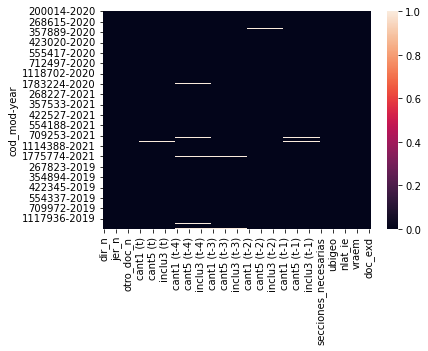

In [33]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

In [45]:
# Imputing missing
df_primaria.fillna(0,inplace=True)

### Finding optimal clusters

In [12]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [48]:
df_primaria_knn = df_primaria[num_primaria]

In [53]:
## Vamos a hacer el grafico del codo. Para esto vamos a probar hacer distintos clusters y vamos a guardar el error (que lo definimos como wcss)
# WCSS --> Wihin Cluster Sum of Squares
wcss = []
for i in range(1,12):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=36963)
  kmeans.fit(df_primaria_knn)
  wcss.append(kmeans.inertia_)

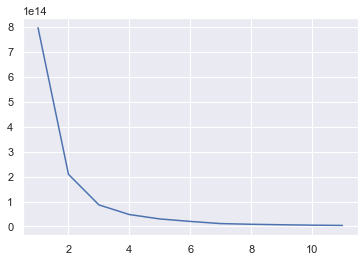

In [54]:
import matplotlib.pyplot as plt
sns.set()
plt.plot(range(1,12),wcss)

In [36]:
df_primaria = df_primaria.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist'])

In [37]:
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]

In [7]:
# Other outcomes not relevant to predict in this version
other_outcomes=['doc_aula_req','aux_req','doc_aula_exd_n', 'doc_aula_exd_c', 'aux_exd']
#df = df.drop(columns=other_outcomes)